# sKCSD tutorial
In this tutorial we will cover three topics: data format for sKCSD estimation, sKCSD method and source visualization. 

In [1]:
from kcsd import sKCSDcell, sKCSD, sample_data_path
from kcsd import utility_functions as utils
from kcsd.utility_functions import LoadData
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
data_fname = os.path.join(sample_data_path, "gang_7x7_200")


In [11]:
data = LoadData(data_fname)

Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/morphology/gang_7x7_200_rows_4_cols_4_xmin_-200_xmax_200_ymin_-200_ymax_200_orientation_3.swc
Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/electrode_positions/elcoord_x_y_z
Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/LFP/MyLFP


Data should be divided into three subdirectories: morphology, electrode_positions and LFP, each containing one file with morphology, electrode_positions and LFP. LoadData currently supports only swc morphology format. LoadData can read in electrode positions as a text file either with 1 column with x postions for each electrode followed by y postions for each electrodes followed by z positions of each electrode; or a textfile with 3 columns with x, y, z electrode postions.  LFPs should be a text file with appropriate numbers of the shape of n_electrodes x n_time_samples. LoadData also allows for initialization of an empty object and reading in arbitrary data files from specific location using assign function: 
data1 = LoadData()
data1.assign('morphology', path_to_morphology_file)
data1.assign('electrode_positions_file', path_to_electrode_positions_file)
data1.assign('LFP', path_to_LFP_file)

Data used in this tutorial was generated using figures/skcsd_paper/run_LFPy.py (class for running example simulations using LFPy). LFPy uses mV for voltage, ms for time and um for distance (or position). sKCSD (and KCSD) requires data in SI units. That is why data used for sKCSD estimation needs to be scaled.

In [12]:
data.LFP /= 1e3
data.morphology[:, 2:5] /= 1e6
data.ele_pos /= 1e6

Let us visualise the current density.

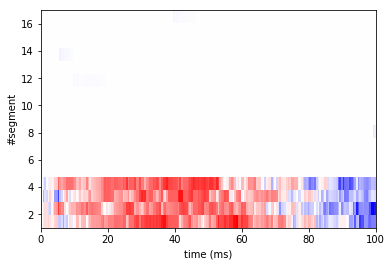

In [13]:
#Other parameters

dt = 0.5
t_stop = 100 #  ms
tolerance = 2e-6
seglen = np.loadtxt(os.path.join(data_fname, 'seglength'))
ground_truth = np.loadtxt(os.path.join(data_fname, 'membcurr'))/seglen[:, None]*1e-3
vmin, vmax =  ground_truth.min(), ground_truth.max()
if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_xlabel('time (ms)')
ax.set_ylabel('#segment')
ax.imshow(ground_truth, origin="lower", aspect="auto", interpolation="none", cmap="bwr", vmin=vmin, vmax=vmax, extent=[0, t_stop, 1, len(seglen)])


To calculate sKCSD you must specify the width of the source (R) and noise level (lambd). For neuron morphologies R is going to be of the order of microns. We specified lambd = 10000, which amounts to roughly 10% noise.

In [ ]:
n_src = 100
R = 8e-6
lambd = 10000
ker = sKCSD(data.ele_pos,
            data.LFP,
            data.morphology,
            n_src_init=n_src,
            src_type='gauss',
            lambd=lambd,
            R_init=R,
            tolerance=tolerance,
            exact=True)

/home/jszmek/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


skcsd.values(estimate) provides potential and current source density. For potential estimate="POT", for  current density estimate='CSD'. By default skcsd.values() provides CSD.

In [42]:
skcsd = ker.values(transformation="segments")
print(skcsd.min(), skcsd.max())


-0.00016152110067751046 0.00020729213957480422


skcsd.values() allows both for transformation to segments and a 3D morphology. By default potential and current density are transformed to a 3D cube spanning from (xmin, ymin, zmin) to (xmax, ymax, zmax). To store cell morphology, morphology loop, source positions and allow easy transformations between morphology (segments), morphology loop and 3D cube, sKCSD uses a separate object sKCSDcell. By default sKCSD uses minimum and maximum neuron coordinates from the swc file.

-0.00018654020717563097 0.00018654020717563097


Text(0.5,1,'estimated current density')

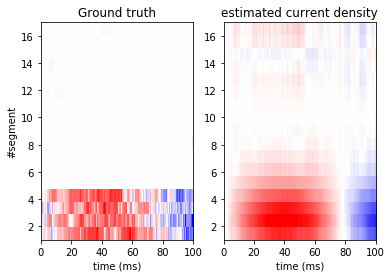

In [46]:
print(vmin, vmax)
fig, ax = plt.subplots(1, 2)
ax[1].set_aspect('equal')
ax[1].set_xlabel('time (ms)')
ax[1].imshow(skcsd, origin="lower", aspect="auto", interpolation="none", cmap="bwr", vmin=vmin, vmax=vmax, extent=[0, t_stop, 1, len(seglen)])
ax[0].set_aspect('equal')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('#segment')
ax[0].imshow(ground_truth, origin="lower", aspect="auto", interpolation="none", cmap="bwr", vmin=vmin, vmax=vmax, extent=[0, t_stop, 1, len(seglen)])
ax[0].set_title('Ground truth')
ax[1].set_title('estimated current density')
